In [1]:
import numpy as np
import tensorflow as tf

np.random.seed(2019)
tf.set_random_seed(2019)

class MLP:
    def __init__(self, n_hidden=30, n_output=1):
        self.n_hidden = n_hidden
        self.n_output = n_output

        # define placeholders for training MLP
        self.x = tf.placeholder(tf.float32, shape=[None, 1])
        self.y = tf.placeholder(tf.float32, shape=[None, 1])
        self.dropout_rate = tf.placeholder(tf.float32)
        self.lr = tf.placeholder(tf.float32)

        self.predictions, self.loss, self.opt = self.build_graph(n_hidden=self.n_hidden, n_output=self.n_output)

    def build_graph(self, n_hidden=30, n_output=1):
        """
        Build computational graph for toy dataset with dropout

        Args:
            n_hidden: the number of hidden units in MLP.
            n_output: the size of output layer (=1)

        Returns:
            prob: probability of prediction (m, 1)
            loss: corss entropy loss
            learning rate: learning rate for optimizer (ex. SGD, RMSprop, Adam, etc.)
        """

        with tf.variable_scope('mlp'):
            # initializers for weight and bias
            w_init = tf.contrib.layers.variance_scaling_initializer()
            b_init = tf.constant_initializer(0.0)

            # 1st hidden layer (input dimension --> n_hidden)
            w0 = tf.get_variable('w0', [self.x.get_shape()[1], n_hidden], initializer=w_init)
            b0 = tf.get_variable('b0', [n_hidden], initializer=b_init)
            h0 = tf.matmul(self.x, w0) + b0
            h0 = tf.nn.relu(h0)
            h0 = tf.nn.dropout(h0, rate=self.dropout_rate)

            # 2nd hidden layer (n_hidden --> n_hidden)
            """
            Please implement the second fully connected layer
            with (n_hidden --> n_hidden)
            """
            w1 = tf.get_variable('w1', [h0.get_shape()[1], n_hidden], initializer=w_init)
            b1 = tf.get_variable('b1', [n_hidden], initializer=b_init)
            h1 = tf.matmul(h0, w1) + b1
            h1 = tf.nn.relu(h1)
            h1 = tf.nn.dropout(h1, rate=self.dropout_rate)

            # 3nd hidden layer (n_hidden --> n_hidden)
            w2 = tf.get_variable('w2', [h1.get_shape()[1], n_hidden], initializer=w_init)
            b2 = tf.get_variable('b2', [n_hidden], initializer=b_init)
            h2 = tf.matmul(h1, w2) + b2
            h2 = tf.nn.relu(h2)
            h2 = tf.nn.dropout(h2, rate=self.dropout_rate)

            # output layer (n_hidden --> n_output)
            wo = tf.get_variable('wo', [h2.get_shape()[1], n_output], initializer=w_init)
            bo = tf.get_variable('bo', [n_output], initializer=b_init)
            predictions = tf.matmul(h2, wo) + bo
            
            # we don't need probability --> just regression problems
            # prob = tf.nn.softmax(logit, axis=1)
            # loss
            # loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(
            #    logits=logit, labels=self.y))
            """
            Please implement the Mean Squared Loss function
            """
            loss = tf.reduce_mean(tf.losses.mean_squared_error(labels=self.y, predictions=predictions))
            # optimizer
            opt = tf.train.AdamOptimizer(learning_rate=self.lr).minimize(loss)
        return predictions, loss, opt

In [2]:
mlp = MLP()
sess = tf.Session(config=tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True)))
sess.run(tf.global_variables_initializer())

W0730 22:21:26.557611 12612 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W0730 22:21:26.610476 12612 deprecation.py:323] From c:\users\ironm\tf-nightly\lib\site-packages\tensorflow\python\ops\losses\losses_impl.py:121: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [3]:
"""
Toy dataset = sine function with standard Gaussian noise ~ N(0, 1^2)
Training data (1-dimensional) --> only from -3 to 3

Test data (1-dimensional) --> from -6 to 6
You don't need to handle this part.
"""
x_train = np.linspace(-3, 3.2, 31, endpoint=False)
noise_train = 0.2 * np.random.randn(31)
y_train = np.sin(x_train) + noise_train

x_train, y_train = np.expand_dims(x_train, -1), np.expand_dims(y_train, -1)

x_test = np.linspace(-6, 6.2, 61, endpoint=False)
noise_test = np.random.randn(61)
y_test = np.sin(x_test) + 0.2 * noise_test

x_test, y_test = np.expand_dims(x_test, -1), np.expand_dims(y_test, -1)

In [4]:
from matplotlib import pyplot as plt
plt.figure()
plt.xlabel("$x$")
plt.ylabel("$y = \sin x + 0.2 \epsilon$ with $\epsilon$ ~ $N(0,1^2)$")
plt.plot(x_train, y_train, 'bo', color='black', label="Train data")
plt.plot(x_test, y_test, 'bo', color='red', label="Test data")
plt.ylim([-1.5, 1.5])
plt.legend(loc='best')
plt.show()

<Figure size 640x480 with 1 Axes>

In [5]:
def train(net, sess, num_epoch=6000):
    # iterating epoch
    for epoch in range(num_epoch):
        # here we use batch gradient descent since the data size is small!!
        feed_dict = {net.x: x_train, 
                     net.y: y_train,
                     net.dropout_rate: 0.3,
                     net.lr: 1e-3
                    }# <-- Please implement this part!
        avg_loss, _ = sess.run([net.loss, net.opt], feed_dict=feed_dict)
        print ('Epoch: ', '%04d' % (epoch + 1), 'cost =', '{:.9f}'.format(avg_loss))
    print ("Learning finished")
    return

In [6]:
def evaluate(net, sess, T=50):
    repeat_predictions = []
    """
    Important thing!!

    Here, repeat prediction has size of (T, num, 1)
    T: How many runs for measuring uncertainty?
    n_test: the number of test data samples
    1: dimensions of outputs
    
    You don't need to modify here
    """
    for i in range(T):
        repeat_predictions.append(sess.run(net.predictions, feed_dict={net.x: x_test,
                                                                       net.y: y_test,
                                                                       net.dropout_rate: 0.3}))
    return repeat_predictions

In [9]:
train(mlp, sess)
repeat_predictions = evaluate(mlp, sess)
repeat_predictions = np.array(repeat_predictions)
mean = np.mean(repeat_predictions, 0)
std = np.std(repeat_predictions, 0)

Epoch:  0001 cost = 0.167811513
Epoch:  0002 cost = 0.154263854
Epoch:  0003 cost = 0.202718168
Epoch:  0004 cost = 0.114784896
Epoch:  0005 cost = 0.084101535
Epoch:  0006 cost = 0.144934475
Epoch:  0007 cost = 0.156438947
Epoch:  0008 cost = 0.176210821
Epoch:  0009 cost = 0.127372667
Epoch:  0010 cost = 0.106992319
Epoch:  0011 cost = 0.139543653
Epoch:  0012 cost = 0.137187958
Epoch:  0013 cost = 0.145183012
Epoch:  0014 cost = 0.123212367
Epoch:  0015 cost = 0.108798057
Epoch:  0016 cost = 0.109472342
Epoch:  0017 cost = 0.118712351
Epoch:  0018 cost = 0.124246448
Epoch:  0019 cost = 0.116742007
Epoch:  0020 cost = 0.163478076
Epoch:  0021 cost = 0.133782610
Epoch:  0022 cost = 0.153646812
Epoch:  0023 cost = 0.160867572
Epoch:  0024 cost = 0.102013804
Epoch:  0025 cost = 0.123388864
Epoch:  0026 cost = 0.148350373
Epoch:  0027 cost = 0.144655973
Epoch:  0028 cost = 0.131917343
Epoch:  0029 cost = 0.140511721
Epoch:  0030 cost = 0.146433368
Epoch:  0031 cost = 0.126291886
Epoch:  

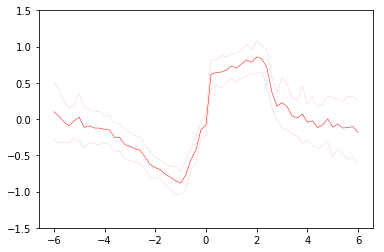

In [10]:
# MC dropout uncertainty figure
plt.figure()
plt.plot(x_test, mean, color='red', lw=0.5)
plt.plot(x_test, mean - std, color='red', lw=0.5, alpha=0.2)
plt.plot(x_test, mean + std, color='red', lw=0.5, alpha=0.2)
plt.ylim([-1.5, 1.5])
plt.show()